In [2]:
library(tidyverse)
library(tidymodels)
library(readxl)
library(dplyr)
library(gridExtra)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
# reading the data
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
download.file(url, "data.xls")
training_data <- read_excel("data.xls", sheet = 2) # sheet 2 => training data
testing_data <- read_excel("data.xls", sheet = 3) # sheet 3 => testing data


# select only the columns we need and making our class as a factor
training_data <- training_data %>%
    select(1:6) %>%
    mutate(UNS = as_factor(UNS))

testing_data <- testing_data %>%
    select(1:6) %>%
    mutate(UNS = as_factor(UNS))

training_data
# testing_data

New names:
* `` -> ...7
* `` -> ...8

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


mean,neighbors
<dbl>,<dbl>
0.8375566,11


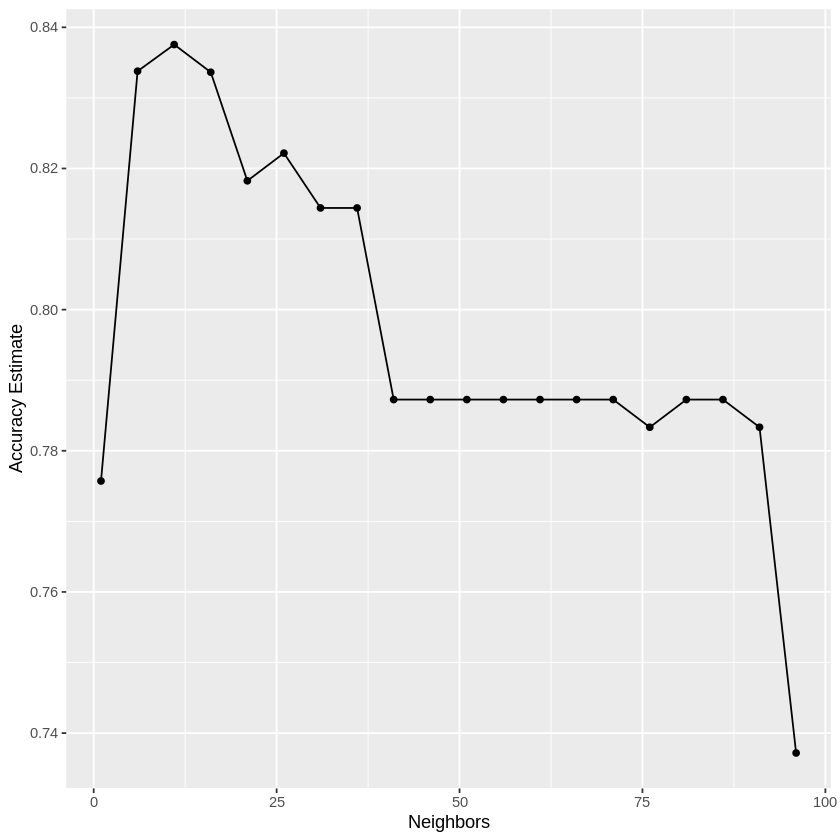

In [4]:
set.seed(1)
# split the data into 5 folds
data_vfold <- vfold_cv(training_data, v = 5, strata = UNS)

# scale and center our data
data_recipe <- recipe(UNS ~ PEG, data = training_data) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

# create model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

# set up differnt K
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

# predict?
knn_results <- workflow() %>%
  add_recipe(data_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = data_vfold, grid = k_vals) %>%
  collect_metrics() 

# get our accuracies
accuracies <- knn_results %>%
    filter(.metric == "accuracy")

# plot accuracy vs K and decide on K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate")

accuracy_vs_k

best_k <- accuracies %>%
    select(mean, neighbors) %>%
    arrange(desc(mean)) %>%
    slice(1)

best_k
# the best K is 11

`summarise()` ungrouping output (override with `.groups` argument)



UNS,average_PEG
<fct>,<dbl>
High,0.77253968
Middle,0.54238636
Low,0.23762651
very_low,0.09083333


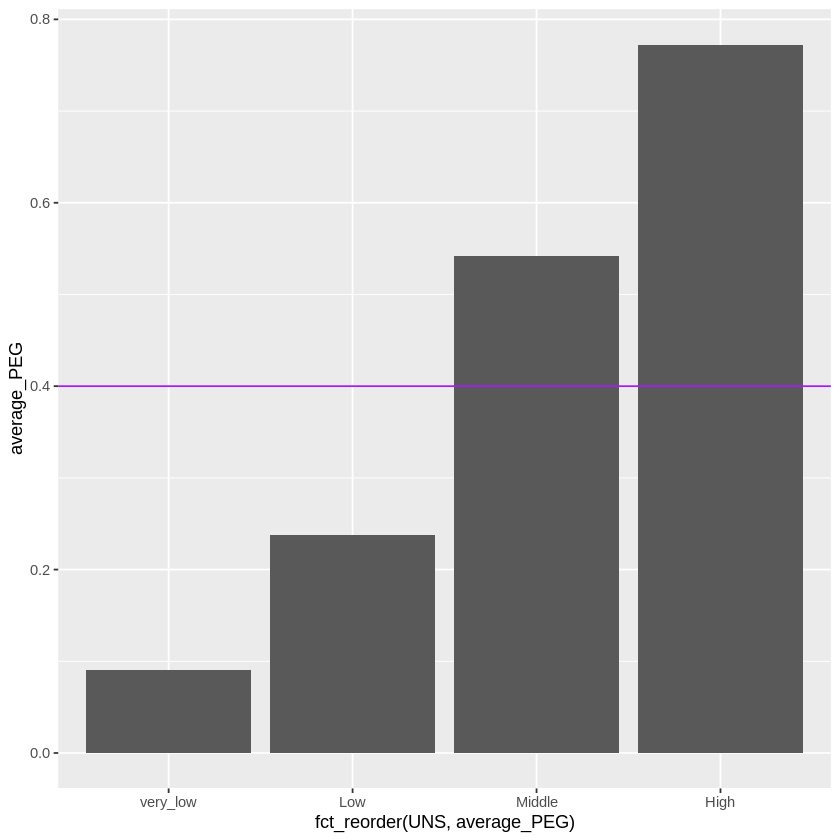

In [14]:
# we need to display each UNS as a bar on x- axis 
# and their average PEG on the y-axis

average_UNS <- training_data %>%
    select('UNS', 'PEG') %>% # select the columns we need
    group_by(UNS) %>% # group_by each UNS class
    summarize(average_PEG = mean(PEG)) %>% # find the average PEG
    arrange(desc(average_PEG))

# plot the bars, re-ordering the bars in increasing order
plot <- average_UNS %>%
    ggplot(aes(fct_reorder(UNS, average_PEG), average_PEG)) +
    geom_bar(stat = 'identity') +
    geom_abline(slope = 0, intercept = 0.4, col = 'Purple') 

average_UNS
plot